# Earthquake_prac
> practice

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Graph Laplacian, PCA, eigenvalue deposition]

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import networkx as nx
import folium
from IPython.display import HTML

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

- t = Year
- x = Latitude
- y = Longitude
- f = Magnitude

##### 1. 데이터 정의

1980 이상 7시간 반 걸림

In [13]:
_df = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1980"').reset_index().iloc[:,1:]
_df

Date  Latitude  Longitude  Magnitude  Year
0      01/01/1980   38.8150   -27.7800        6.7  1980
1      01/02/1980    5.9840   126.1880        6.0  1980
2      01/02/1980    5.9350   126.1320        5.7  1980
3      01/03/1980    0.0360    67.1750        5.7  1980
4      01/03/1980    5.6880   126.0230        5.8  1980
...           ...       ...        ...        ...   ...
18010  12/28/2016   38.3917  -118.8941        5.6  2016
18011  12/28/2016   38.3777  -118.8957        5.5  2016
18012  12/28/2016   36.9179   140.4262        5.9  2016
18013  12/29/2016   -9.0283   118.6639        6.3  2016
18014  12/30/2016   37.3973   141.4103        5.5  2016

[18015 rows x 5 columns]

##### 2. $f(x) = y + \epsilon$ 정의
- $y$ = Magnitude,  지진 규모로 정의

In [14]:
f = _df.loc[:,"Magnitude"]

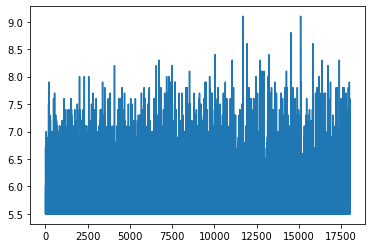

In [15]:
plt.plot(f,'-')

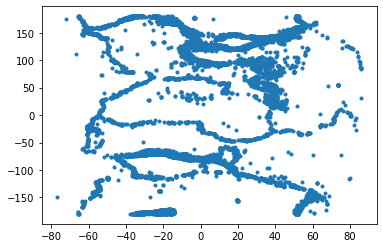

In [16]:
plt.plot( _df.Latitude,_df.Longitude,'.')

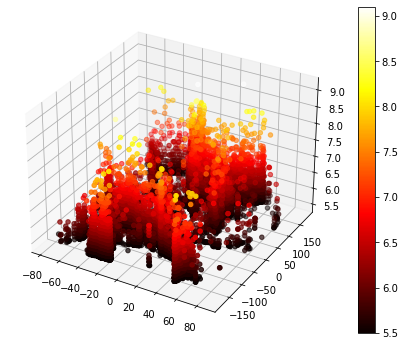

In [17]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(_df.Latitude, _df.Longitude, _df.Magnitude, c= _df.Magnitude,  cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [18]:
_dfgraph = df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).query('Year>="1980"').reset_index().iloc[:,1:].reset_index()

/tmp/ipykernel_180670/2573661339.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_zticklabels(_dfgraph.Year)


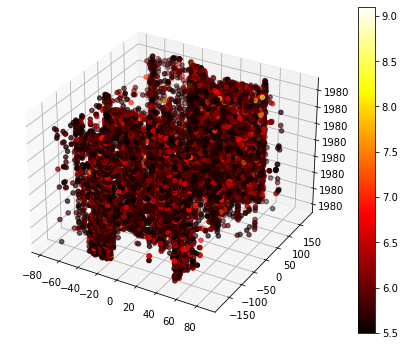

In [19]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_zticklabels(_dfgraph.Year)
img = ax.scatter(_dfgraph.Latitude, _dfgraph.Longitude, _dfgraph.index,c= _dfgraph.Magnitude, cmap=plt.hot())
fig.colorbar(img)
plt.show()

In [20]:
#collapse
lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-1980)]

In [21]:
#collapse
from folium import plugins 
data=(np.random.normal(size=(100,3)) + np.array([[28,77,5]])).tolist() # (좌표,weight)를 의미함, 그리고 numpy는 list가 될 수 없기 때문에 tolist 옵션 사용
m=folium.Map([28,77],zoom_start=6,scrollWheelZoom=False)
plugins.HeatMap(data).add_to(m) 

In [22]:
m=folium.Map(scrollWheelZoom=False)
plugins.HeatMapWithTime(lst,radius=5,index=list(range(1980,2016))).add_to(m)
m

In [68]:
from mpl_toolkits.basemap import Basemap

ImportError: cannot import name 'dedent' from 'matplotlib.cbook' (/home/csy/anaconda3/envs/csy/lib/python3.8/site-packages/matplotlib/cbook/__init__.py)

In [433]:
#collapse

from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

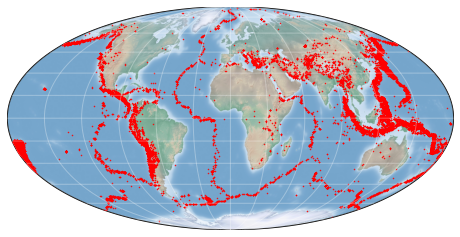

In [434]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

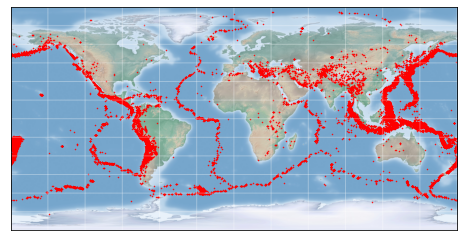

In [435]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
m.plot(x, y, 'r.', markersize=1)
draw_map(m)

##### 3. $(x_i,y_i)$와 $(x_j,y_j)$ 사이의 유클리드 거리 정의
- $x$ = Latitude, 위도로 정의
- $y$ = Longitude, 경도로 정의
- 지진의 영향이 주변에만 끼치는 것을 고려하여 경도, 위도의 차이가 90도 이내인 경우만 거리 계산

$$dist((x_i,y_i),(x_j,y_j)) = \sqrt{((x_j-x_i)^2-(y_j-y_i)^2}$$

In [23]:
def dist(i,j):
    if abs( _df.Latitude[j] - _df.Latitude[i] ) > 90: 
        return 10000  
    elif abs( _df.Longitude[j] - _df.Longitude[i] ) > 90: 
        return 10000
    else:
        return np.sqrt( ( ( _df.Latitude[j] - _df.Latitude[i] )**2) + ( ( _df.Longitude[j] - _df.Longitude[i])**2) )

##### 4. 거리를 이용한 $W_{i,j}$ 행렬 정의
- a weighted adjacency matrix $W$
- 동일한 지점 상의 거리는 0이 되어 $W_{i,j}$가 1이 될 것이다(대각행렬은 모두 1)
- 연결강도로 생각

$$W_{i,j}=\begin{cases}{exp(-\frac{[dist(i,j)]^2}{2\theta^2})} & \quad \text{if } dist(i,j) \leq κ \\ 0 & \quad \text{otherwise} \end{cases}$$

In [24]:
def weight(i,j,theta=150,kappa=1000):
    return np.exp( -np.abs(dist(i,j))**2 / (2*theta**2) ) if dist(i,j) <= kappa else 0

6시간 정도 걸림

In [25]:
W = np.array([[weight(i,j) for i in range(len(_df))] for j in range(len(_df))])

In [26]:
W.round(3)

array([[1.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 1.   , 1.   , ..., 0.975, 0.994, 0.973],
       [0.   , 1.   , 1.   , ..., 0.974, 0.994, 0.973],
       ...,
       [0.   , 0.975, 0.974, ..., 1.   , 0.944, 1.   ],
       [0.   , 0.994, 0.994, ..., 0.944, 1.   , 0.942],
       [0.   , 0.973, 0.973, ..., 1.   , 0.942, 1.   ]])

(array([1.82473166e+08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.24600000e+03, 2.44446200e+06,
        3.04767400e+07, 1.09144611e+08]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

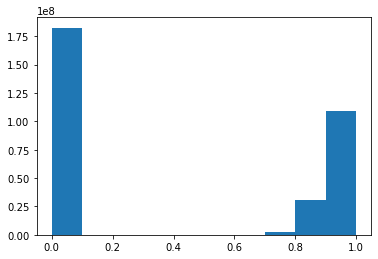

In [27]:
plt.hist(W.reshape(-1))

그래프

nx.draw(nx.Graph(W))

##### 5. $W_{i,j}$ 행렬을 이용한 차수 행렬 정의
- $D$ = Degree Matrix

In [28]:
D = np.diag(W.sum(axis=1))

In [29]:
D

array([[ 3578.13338639,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        , 10290.14834876,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        , 10289.94278233, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         9774.22328895,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        , 10272.51002303,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  9751.63187566]])

##### 6. Graph Laplacian matrix 정의
- $L = D - W$

In [30]:
L = D - W

In [31]:
L

array([[ 3.57713339e+03,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.02891483e+04, -9.99999877e-01, ...,
        -9.74559591e-01, -9.93753342e-01, -9.73285239e-01],
       [ 0.00000000e+00, -9.99999877e-01,  1.02889428e+04, ...,
        -9.74459287e-01, -9.93804320e-01, -9.73181667e-01],
       ...,
       [ 0.00000000e+00, -9.74559591e-01, -9.74459287e-01, ...,
         9.77322329e+03, -9.44181666e-01, -9.99973372e-01],
       [ 0.00000000e+00, -9.93753342e-01, -9.93804320e-01, ...,
        -9.44181666e-01,  1.02715100e+04, -9.42335310e-01],
       [ 0.00000000e+00, -9.73285239e-01, -9.73181667e-01, ...,
        -9.99973372e-01, -9.42335310e-01,  9.75063188e+03]])

##### 7. 고유값 분해
- ${\bf L} = {\boldsymbol\Psi} {\boldsymbol\Lambda} {\boldsymbol\Psi}^\top$

In [32]:
λ, Ψ = np.linalg.eig(L)

In [33]:
Λ = np.diag(λ)

---

푸리에

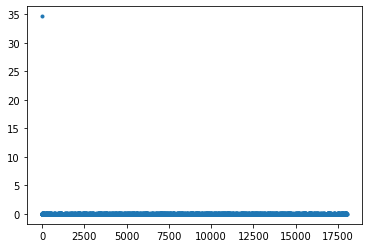

In [34]:
fbar = np.abs(np.fft.fft(f**2))/len(f)
plt.plot(fbar,'.')

In [35]:
fbar[0] 

34.68253024701637

In [36]:
len(f)/2

9007.5

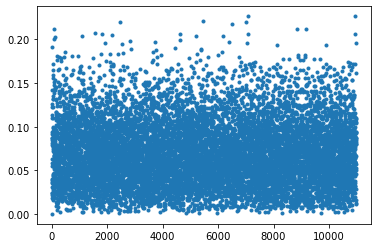

In [37]:
fbar2=np.zeros(10978)
#fbar2[0] = fbar[0] 
fbar2[0] = 0
fbar2[1:10978] = 2*fbar[1:10978]
plt.plot(fbar2,'.')

In [38]:
fbar2[:10]

array([0.        , 0.0365602 , 0.1231017 , 0.03533143, 0.03085851,
       0.19118625, 0.08708694, 0.02447058, 0.02343862, 0.09155752])

---

##### 8. p
- $compk = f @ np.outer(Ψ[:,k], Ψ[:,k]) $
    - $k = 1, 2, 3, 8000$
- $p = (sum(comp1^2),sum(comp2^2),…,sum(comp8000^2))$
- $p = p/sum(p)$
    - 0.2 0.1  ...
- —> 5개의 최상의 컴포넌트만 골랐더니 70%

In [39]:
def comp(i):
    return (f @ np.outer( Ψ[:,i], Ψ[:,i]))

In [40]:
def p(i):
    return sum(comp(i)**2)

In [41]:
p(0)

621620.5734246754

In [42]:
array_1 = np.array([p(i) for i in range(1,len(_df))])

In [43]:
varprop = array_1/array_1.sum()

In [44]:
_index = pd.DataFrame({'index':range(1,len(_df)),'varprop':varprop}).sort_values('varprop',ascending=False)
_indexlst = _index.iloc[:25,0].tolist()

In [45]:
_indexlst

[15503,
 12429,
 10593,
 1794,
 10157,
 1967,
 1,
 9795,
 13728,
 16675,
 4990,
 11769,
 10636,
 3519,
 6972,
 4694,
 526,
 10592,
 3235,
 6611,
 8934,
 12451,
 7782,
 14016,
 1706]

(0.0, 40.0)

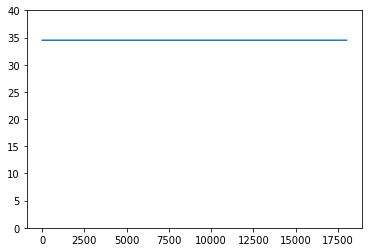

In [46]:
plt.plot( (f @ np.outer( Ψ[:,0], Ψ[:,0]))**2)
plt.ylim(0,40)

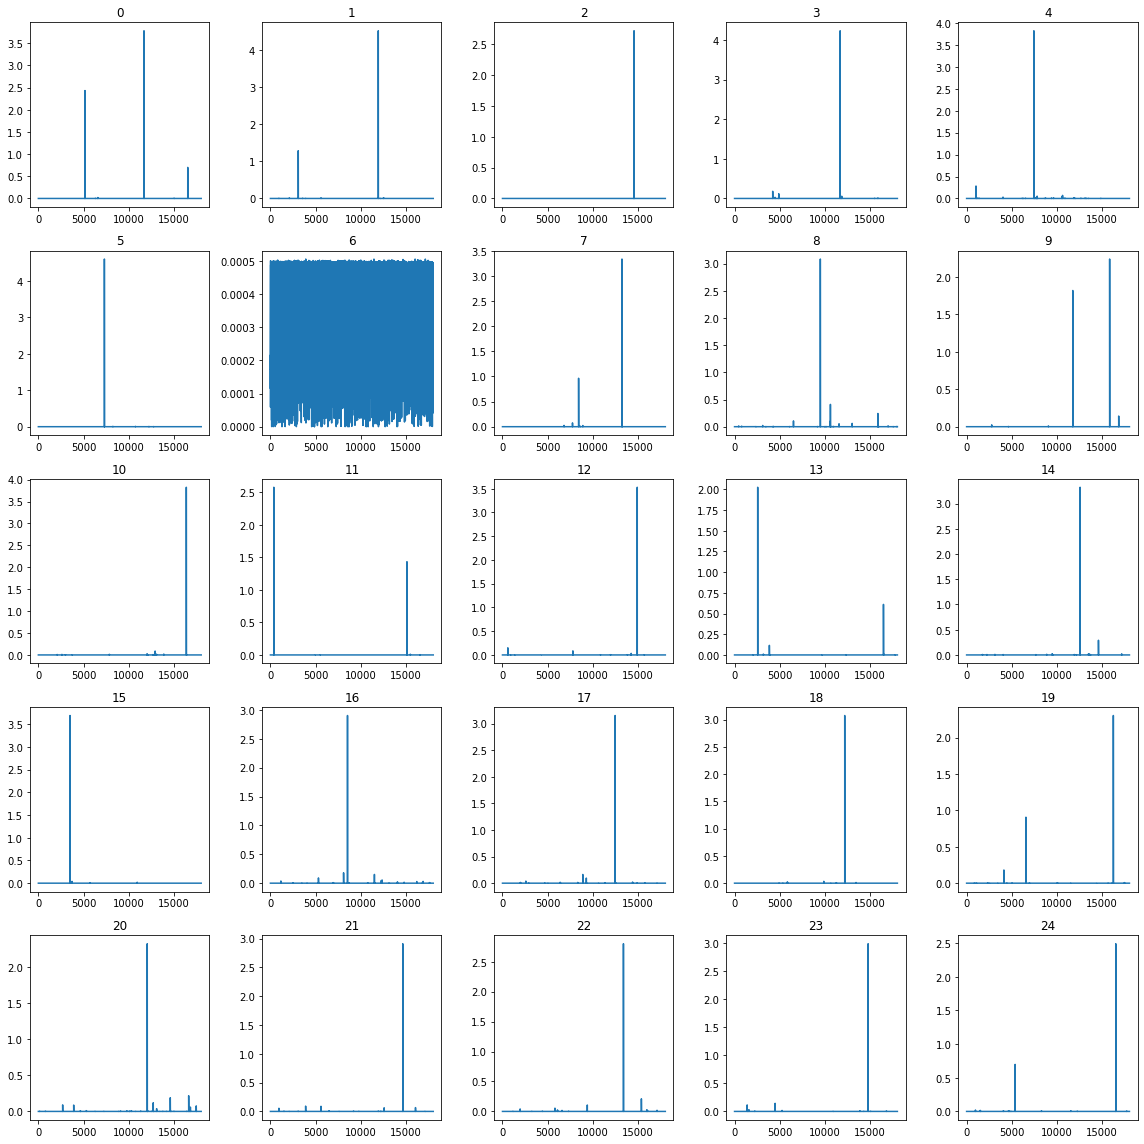

In [47]:
fig,ax =plt.subplots(5,5)
k=0
for i in range(5):
    for j in range(5):
        ax[i][j].plot((f @ np.outer(Ψ[:,_indexlst[k]], Ψ[:,_indexlst[k]]))**2)
        # ax[i][j].set_ylim([-2,7])
        ax[i][j].set_title(k)
        k=k+1
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()        

##### 9. PCA

In [48]:
comp1 = f @ np.outer( Ψ[:,0], Ψ[:,0])

In [49]:
comp2 = f @ np.outer( Ψ[:,_indexlst[0]], Ψ[:,_indexlst[0]])

In [50]:
comp3 = f @ np.outer( Ψ[:,_indexlst[1]], Ψ[:,_indexlst[1]])

In [51]:
comp4 = f @ np.outer( Ψ[:,_indexlst[2]], Ψ[:,_indexlst[2]])

In [52]:
comp5 = f @ np.outer( Ψ[:,_indexlst[3]], Ψ[:,_indexlst[3]])

In [53]:
_df["comp1"] = comp1

In [54]:
_df["comp2"] = comp2

In [55]:
_df["comp3"] = comp3

In [56]:
_df["comp4"] = comp4

In [57]:
_df["comp5"] = comp5

In [58]:
#collapse
_lst=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,3]].\
to_numpy().tolist() for i in range(2016-1980)]

In [59]:
#collapse
__lst1=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,5]].\
to_numpy().tolist() for i in range(2016-1980)]

In [60]:
#collapse
__lst2=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,6]].\
to_numpy().tolist() for i in range(2016-1980)]

In [62]:
#collapse
__lst3=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,7]].\
to_numpy().tolist() for i in range(2016-1980)]

In [63]:
#collapse
__lst4=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,8]].\
to_numpy().tolist() for i in range(2016-1980)]

In [64]:
#collapse
__lst5=[_df.assign(Year=list(map(lambda x: x.split('/')[-1], _df.Date))).\
groupby('Year').\
pipe(list)[i][1].iloc[:,[1,2,9]].\
to_numpy().tolist() for i in range(2016-1980)]

In [65]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(1980,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

In [71]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst2,radius=50,index=list(range(1980,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

---

- (3.7750 95.9320, -10.1490 113.6860) 인도해
- (0.7300 122.7020, -0.3460 122.1890, 5.3040 124.3820)는 인도네시아
- 마지막 필리핀

In [84]:
_df.sort_values("comp2")[0:10]

Date  Latitude  Longitude  Magnitude  Year     comp1     comp2  \
5158   07/23/1991    3.7750    95.9320        5.6  1991  5.874157 -1.559617   
16526  10/13/2013    3.9633    95.8634        5.6  2013  5.874157 -0.836791   
6575   06/15/1994  -10.1490   113.6860        5.5  1994  5.874157 -0.143689   
6317   12/07/1993    0.7300   122.7020        5.6  1993  5.874157 -0.073032   
3816   10/28/1988   -0.3460   122.1890        5.6  1988  5.874157 -0.046446   
10402  04/20/2002    5.3040   124.3820        5.7  2002  5.874157 -0.041519   
10417  05/04/2002    5.2830   124.4060        5.7  2002  5.874157 -0.026851   
6546   06/03/1994  -10.4680   112.9620        5.6  1994  5.874157 -0.022405   
6558   06/05/1994  -10.6450   112.6540        5.5  1994  5.874157 -0.020495   
1905   11/27/1984    7.6010   124.3880        5.9  1984  5.874157 -0.019692   

          comp3         comp4     comp5  
5158  -0.001167  3.960426e-07  0.000036  
16526 -0.001165  3.964143e-07  0.000035  
6575  -0.001972  7.815133e-09  0.000041  
6317  -0.002403 -8.178724e-08  0.000025  
3816  -0.002500 -7.830131e-08  0.000027  
10402 -0.001960 -9.319337e-08  0.000017  
10417 -0.001976 -9.321610e-08  0.000017  
6546  -0.001965  1.999649e-08  0.000042  
6558  -0.001942  2.670365e-08  0.000042  
1905  -0.001834 -9.286977e-08  0.000014

---

In [72]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst3,radius=50,index=list(range(1980,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

---


- (15.877 120.226) 필리핀
- (3.090 122.005, -0.944 121.487) 인도네시아 필리핀 사이
- (-6.650 101.630, 1.868 97.129, 2.383 97.048, -9.343 113.058, -0.429 97.672, -9.414 112.933) 인도해
- (-0.847 121.554) 인도네시아

In [85]:
_df.sort_values("comp3")[0:10]

Date  Latitude  Longitude  Magnitude  Year     comp1     comp2  \
3081   04/25/1987    15.877    120.226        5.6  1987  5.874157 -0.000406   
5596   07/12/1992     3.090    122.005        5.8  1992  5.874157 -0.000657   
942    11/11/1982    -6.650    101.630        6.3  1982  5.874157 -0.000563   
3897   12/20/1988     1.868     97.129        5.5  1988  5.874157 -0.000604   
9195   11/25/1999    -0.944    121.487        5.7  1999  5.874157 -0.000690   
14642  04/06/2010     2.383     97.048        7.8  2010  5.874157 -0.000603   
6484   04/25/1994    -9.343    113.058        5.8  1994  5.874157 -0.000504   
16049  10/03/2012    -0.429     97.672        5.7  2012  5.874157 -0.000627   
1502   01/26/1984    -9.414    112.933        5.6  1984  5.874157 -0.000491   
9787   12/10/2000    -0.847    121.554        5.5  2000  5.874157 -0.000700   

          comp3         comp4     comp5  
3081  -1.133571 -6.358825e-08  0.000003  
5596  -0.128950 -7.607687e-08  0.000022  
942   -0.074562  3.581726e-07  0.000044  
3897  -0.059860  3.898901e-07  0.000037  
9195  -0.048201 -7.333307e-08  0.000027  
14642 -0.046166  3.904187e-07  0.000036  
6484  -0.044780  1.783845e-08  0.000040  
16049 -0.038312  3.857439e-07  0.000040  
1502  -0.037996  2.264689e-08  0.000040  
9787  -0.037691 -7.398353e-08  0.000027

---

In [73]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst4,radius=50,index=list(range(1980,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst5,radius=5,index=list(range(2000,2016))).add_to(_m)
_m

---

- 남태평양 (-36.1290 -73.2570, -36.3656 -73.7481, -20.1870 -174.1230, 54.5200 -161.7100, -35.7700 -73.1160)
- 남대서양(-1.0800 -13.8870, -17.3520 -14.5000, 53.8730 -35.1270)
- 칠레(-36.0740 -70.5700, -35.9250 -71.4150 )

In [86]:
_df.sort_values("comp4")[0:10]

Date  Latitude  Longitude  Magnitude  Year     comp1  \
14557  02/27/2010  -36.1290   -73.2570        5.5  2010  5.874157   
17286  06/20/2015  -36.3656   -73.7481        5.5  2015  5.874157   
12461  05/03/2006  -20.1870  -174.1230        8.0  2006  5.874157   
13307  10/26/2007   54.5200  -161.7100        5.5  2007  5.874157   
4712   08/05/1990   -1.0800   -13.8870        6.4  1990  5.874157   
15917  06/07/2012  -36.0740   -70.5700        6.0  2012  5.874157   
6010   05/02/1993  -17.3520   -14.5000        5.6  1993  5.874157   
16170  01/20/2013   53.8730   -35.1270        5.5  2013  5.874157   
4580   05/14/1990  -35.9250   -71.4150        6.2  1990  5.874157   
15511  07/28/2011  -35.7700   -73.1160        5.7  2011  5.874157   

              comp2         comp3     comp4         comp5  
14557 -3.523880e-08  5.604932e-07 -1.649497  1.433940e-06  
17286 -2.721405e-08  5.116190e-07 -0.022038  1.384173e-06  
12461 -2.818907e-08  1.167926e-07 -0.005989  5.010060e-07  
13307 -3.048350e-08  1.001732e-07 -0.005420  2.545135e-07  
4712  -2.181345e-06  6.418868e-06 -0.002943 -9.293941e-05  
15917 -8.344892e-08  8.519939e-07 -0.002045  1.687399e-06  
6010  -2.129102e-06  6.209371e-06 -0.001705 -8.919450e-05  
16170 -1.545532e-06  5.726572e-06 -0.001514  1.783531e-05  
4580  -6.952172e-08  7.687805e-07 -0.001388  1.606133e-06  
15511 -3.462644e-08  5.594526e-07 -0.001315  1.425145e-06

---

In [74]:
_m=folium.Map(scrollWheelZoom=False)
#plugins.HeatMapWithTime(_lst,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst1,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst2,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst3,radius=5,index=list(range(2000,2016))).add_to(_m)
#plugins.HeatMapWithTime(__lst4,radius=5,index=list(range(2000,2016))).add_to(_m)
plugins.HeatMapWithTime(__lst5,radius=50,index=list(range(1980,2016))).add_to(_m)
_m

---

- 인도해 (-52.8100 140.3160, -52.8240 140.2280, -52.8670 140.2900, -52.9190 140.0990)
- 아프가니스탄 (37.6120 70.3380)
- 테평양 (49.3100 161.4480) 아프가니스탄 위
- 타지키스탄 ( 38.6120 70.3540)
- 태즈먼 해(-48.7860 164.3570, -48.7330 164.6720, -48.8526 164.4453) 뉴질랜드 아리

In [87]:
_df.sort_values("comp5")[0:10]

Date  Latitude  Longitude  Magnitude  Year     comp1  \
4222   09/05/1989  -52.8100   140.3160        5.7  1989  5.874157   
4890   12/20/1990   37.6120    70.3380        5.6  1990  5.874157   
11859  02/06/2005  -52.8240   140.2280        5.6  2005  5.874157   
11684  12/23/2004  -49.3100   161.4480        5.6  2004  5.874157   
15856  04/22/2012  -52.8670   140.2900        5.6  2012  5.874157   
4021   04/13/1989  -52.9190   140.0990        5.9  1989  5.874157   
15885  05/12/2012   38.6120    70.3540        5.7  2012  5.874157   
483    05/25/1981  -48.7860   164.3570        7.6  1981  5.874157   
14619  03/18/2010  -48.7330   164.6720        5.6  2010  5.874157   
17068  12/01/2014  -48.8526   164.4453        5.7  2014  5.874157   

              comp2     comp3         comp4     comp5  
4222  -1.163430e-06  0.000022 -2.510039e-07 -0.425536  
4890  -6.722029e-07  0.000021 -8.100647e-08 -0.345483  
11859 -1.148970e-06  0.000022 -2.510315e-07 -0.236082  
11684 -4.064986e-06  0.000030 -2.721909e-07 -0.198362  
15856 -1.162978e-06  0.000022 -2.512746e-07 -0.112462  
4021  -1.155308e-06  0.000022 -2.511289e-07 -0.043710  
15885 -6.330017e-07  0.000021 -8.527080e-08 -0.020816  
483   -4.421756e-06  0.000031 -2.770250e-07 -0.018574  
14619 -4.464312e-06  0.000031 -2.774496e-07 -0.016590  
17068 -4.431765e-06  0.000031 -2.772349e-07 -0.016399

---

ref: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

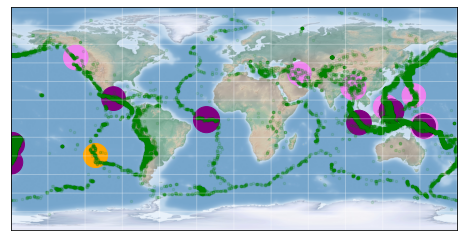

In [472]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)

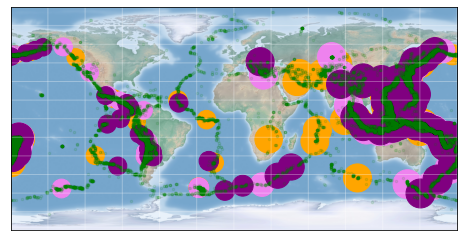

In [476]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0:100]], y[np.argsort(λ)[0:100]], color='orange', s=abs(f_hat[np.argsort(λ)[0:100]])*scale)
m.scatter(x[np.argsort(λ)[101:200]], y[np.argsort(λ)[101:200]], color='violet', s=abs(f_hat[np.argsort(λ)[101:200]])*scale)
m.scatter(x[np.argsort(λ)[201:300]], y[np.argsort(λ)[201:300]], color='purple', s=abs(f_hat[np.argsort(λ)[201:300]])*scale)
draw_map(m)

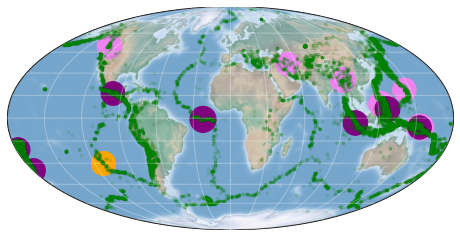

In [474]:
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='moll', resolution=None,
            lat_0=0, lon_0=0)
lon = _df.Longitude
lat = _df.Latitude
x,y = m(lon, lat)
scale = 100
m.plot(x, y, 'g.', markersize=5, alpha=0.1)
#m.plot(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], 'r-', markersize=10)
m.scatter(x[np.argsort(λ)[0]], y[np.argsort(λ)[0]], color='orange', s=abs(f[np.argsort(λ)[0]])*scale)
m.scatter(x[np.argsort(λ)[1:10]], y[np.argsort(λ)[1:10]], color='violet', s=abs(f[np.argsort(λ)[1:10]])*scale)
m.scatter(x[np.argsort(λ)[11:20]], y[np.argsort(λ)[11:20]], color='purple', s=abs(f[np.argsort(λ)[11:20]])*scale)
draw_map(m)